Initialize. Call the commandoes:

In [1]:
# Initialization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.integrate import odeint
from sympy.solvers import solve
from sympy import Symbol
import math
from math import exp, expm1
from dataclasses import dataclass

In [2]:
#Defining the classes:
class BatchReactant:
    def __init__(self, Name, Number, Coefficient, InitialConcentration, Order, EndConcentration):
        self.Name = Name # The reactant is given a name 
        self.Number = Number # The reactant is given a number
        self.Coefficient = Coefficient # The reactant coefficient  
        self.InitialConcentration = InitialConcentration # The reactant concentration
        self.Order = Order # The reactant order
        self.EndConcentration = EndConcentration # The unknown end concentration. 

reactant = [BatchReactant("A", 1, 1, 0.07174, 1, 'X')]

class BatchProduct:
    def __init__(self, Name, Coefficient, InitialConcentration, EndConcentration):
        self.Name = Name #The product is given a name
        self.Coefficient = Coefficient
        self.InitialConcentration = InitialConcentration
        self.EndConcentration = EndConcentration

product = [BatchProduct("B", 2, 0, 'X')]

class BatchReaction:
    def __init__(self, Reaction, Conversion, RateConstant_forward, RateConstant_backward, K_C):
        self.Reaction = Reaction
        self.Conversion = Conversion
        self.RateConstant_forward = RateConstant_forward
        self.RateConstant_backward = RateConstant_backward
        self.K_C = K_C
        
reaction = BatchReaction("Reaction 1", 1, 0.5, 0.5/0.1, 'X')

# The reaction is given a name
# The conversion is entered as Convension 
# The rate is entered as Rate
# The volume of the batch is constant and entered as Volume

In [3]:
# Finding the limiting reactant amount
Amount = [];
for r in reactant:
    amount = r.InitialConcentration/r.Coefficient
    Amount.append(amount)
    Limit_amount = min(Amount)
    if Limit_amount == amount:
        limit_coef = r.Coefficient 
        limit_concentration = r.InitialConcentration
        limit_number = r.Number
        limit_name = r.Name
    print(limit_name)

A


In [4]:
# Calculate K_C
reaction.K_C = reaction.RateConstant_forward/reaction.RateConstant_backward
print('The concentration equilibrium constant for ' + str(reaction.Reaction) + ', is ' + str(reaction.K_C))

The concentration equilibrium constant for Reaction 1, is 0.1


In [5]:
# Equilibrium expressions for reactants and products
Xe = Symbol('Xe')
for r in reactant:
    reac_eq = (r.InitialConcentration-r.Coefficient/limit_coef*limit_concentration*Xe)**(r.Coefficient)
for p in product:
    prod_eq = (p.InitialConcentration+p.Coefficient/limit_coef*limit_concentration*Xe)**(p.Coefficient)

Xe_value = solve(prod_eq/reac_eq - reaction.K_C , Xe)

for num in Xe_value:  
    if num >= 0:
        Xe_value = num
print(Xe_value)

0.441259737222201


In [6]:
# End concentration reactant
for r in reactant:
    r.EndConcentration = r.InitialConcentration-r.Coefficient/limit_coef*limit_concentration*Xe_value

In [7]:
# End concentration products
for p in product:
    p.EndConcentration = p.InitialConcentration+p.Coefficient/limit_coef*limit_concentration*Xe_value

In [8]:
# Printing the end concentrations:
for r in reactant:
    print('The final concentration of ' + str(r.Name) + ', is ' + str(r.EndConcentration))
for p in product:
    print('The final concentration of ' + str(p.Name) + ', is ' + str(p.EndConcentration))

The final concentration of A, is 0.0400840264516793
The final concentration of B, is 0.0633119470966415


In [11]:
#The mixing time for the reaction is now calculated:
def integrand(X):
    rate_for = 1;
    rate_back = 1;
    for r in reactant: 
        rate_f = (r.InitialConcentration-r.Coefficient/limit_coef*limit_concentration*X)**(r.Coefficient)
        rate_for = rate_f*rate_for
    for p in product:
        rate_b = (p.InitialConcentration+p.Coefficient/limit_coef*limit_concentration*X)**(p.Coefficient)
        rate_back = rate_b*rate_back
    return limit_concentration/(reaction.RateConstant_forward*(rate_for-rate_back/reaction.K_C))
t_react, err = quad(integrand, 0, Xe_value)
print(t_react)

21.09940134660859


C:\Users\anna9\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  if sys.path[0] == '':


In [12]:
#The time is made into a vector
time = np.linspace(0,t_react,num=100)

In [13]:
# The reaction kinetics for the reactants 
Concentration_reactant_initial = [];
Order_reactant = [];
for r in reactant:
    Concentration_reactant_initial.append(r.InitialConcentration)
    Order_reactant.append(r.Order)

In [14]:
# Model the system for the reactants
def model_reactant(Conc_r, time):
    rate_r = 1;
    for c in range(len(Concentration_reactant_initial)):
        Q1 = Conc_r[c-1]**Order_reactant[c-1]
        rate_r = rate_r * Q1
    dCrdt = [];
    for r in reactant:
        dCrdt.append(-reaction.RateConstant_forward*rate_r*r.Coefficient/limit_coef)
    return dCrdt

In [15]:
#Solve the reactant system
sol_r = odeint(model_reactant, Concentration_reactant_initial, time)

In [16]:
# Finding the limiting solution vector:
reactant_limiting_solution = sol_r[:,(limit_number-1)]

In [17]:
# Model the system for the products 
dCpdt = [];
for p in product:
    dCpdt.append(p.InitialConcentration+p.Coefficient/limit_coef*(limit_concentration - reactant_limiting_solution))

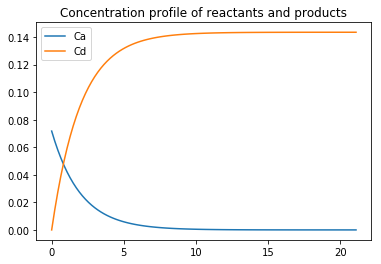

In [18]:
#Plot of the products and reactants:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(time,sol_r[:,0], label = 'Ca')
ax.plot(time,dCpdt[0], label = 'Cd')
plt.title('Concentration profile of reactants and products')
ax.legend()
plt.show()